In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from astra.torch.models import EfficientNet,ResNetClassifier, MLP, MLPClassifier, EfficientNetClassifier
from astra.torch.utils import count_params
print(count_params(EfficientNetClassifier()))
print(count_params(ResNetClassifier()))

{'total_params': 4664446, 'trainable_params': 4664446, 'non_trainable_params': 0}
{'total_params': 11440194, 'trainable_params': 11440194, 'non_trainable_params': 0}


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import copy
import time
import os
import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

### transforms for downstream tasks

In [4]:
transform_test = transforms.Compose([
        transforms.Resize(224),
        # transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

transform_eval = transforms.Compose([
        transforms.RandomResizedCrop((224,224), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(224),
        # transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])


In [5]:
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")
loaded_data1 = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")
images= loaded_data1['images']
labels = loaded_data1['labels']
images = images / 255
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
images1 = loaded_data['images']
labels1 = loaded_data['labels']
images1 = images1 / 255
images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
print(images1.shape)
print(labels1.shape)
print(images.shape)
print(labels.shape)
train_images = images[:225]
train_labels = labels[:225]
test_images = images1
test_labels = labels1

torch.Size([10025, 3, 224, 224])
torch.Size([10025])
torch.Size([25500, 3, 224, 224])
torch.Size([25500])


In [6]:
train_labels_count = (train_labels == 1).sum()
test_labels_count = (test_labels == 1).sum()

print("Number of train labels with value 1:", train_labels_count)
print("Number of test labels with value 1:", test_labels_count)
train_images=transform_eval(train_images)
test_images=transform_test(test_images)

Number of train labels with value 1: tensor(14)
Number of test labels with value 1: tensor(1042)


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### Data preporcessing for how much percentage of the data is used for finetune

In [7]:
print(train_images.shape)
print(test_images.shape)
train_set=torch.utils.data.TensorDataset(train_images,train_labels)
test_set=torch.utils.data.TensorDataset(test_images,test_labels)
train_loader=torch.utils.data.DataLoader(train_set,batch_size=512,shuffle=True,num_workers=8)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=512,shuffle=False,num_workers=8)

torch.Size([225, 3, 224, 224])
torch.Size([10025, 3, 224, 224])


In [8]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
class SimCLR_model(nn.Module):
    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.fc=nn.Linear(n_features, n_features)

        self.base_encoder.linear = Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )

    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)
        
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
        
        return h_i, h_j, z_i, z_j

In [9]:
base_encoder = ResNet50()
projection_dim=224
n_features= base_encoder.fc.in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)
net= net.to(device)
# net
print(base_encoder.fc.weight) #weights of the linear layer before loading the model with SimCLR

path_paramsend = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/paramsend_bs_restart_r_bk_1.pt"
checkpoint = torch.load(path_paramsend, map_location=torch.device('cpu'))
loss= checkpoint['loss']
epoch = checkpoint['epoch']
start_epoch=0
net.load_state_dict(checkpoint['net'])
epoch

Parameter containing:
tensor([[ 0.0170, -0.0209,  0.0127,  ..., -0.0056, -0.0187,  0.0213],
        [-0.0151, -0.0046, -0.0063,  ..., -0.0015,  0.0048,  0.0113],
        [-0.0194,  0.0042, -0.0198,  ...,  0.0078,  0.0213, -0.0166],
        ...,
        [-0.0014,  0.0164,  0.0119,  ..., -0.0190, -0.0065,  0.0109],
        [-0.0159,  0.0203, -0.0091,  ...,  0.0113, -0.0147, -0.0192],
        [ 0.0039, -0.0093,  0.0167,  ..., -0.0040,  0.0006, -0.0119]],
       device='cuda:0', requires_grad=True)


500

In [10]:
classes = ('positive', 'negetive')
net_eval= base_encoder
n_features= base_encoder.fc.in_features
print(n_features)
net_eval.linear=nn.Linear(n_features, len(classes)) 
print(net_eval.linear)
optimizer= torch.optim.SGD(net_eval.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
net_eval.to(device)
print(net_eval.fc.weight) #weights of the linear layer after loading the model with SimCLR

2048
Linear(in_features=2048, out_features=2, bias=True)
Parameter containing:
tensor([[-0.0091, -0.0156, -0.0191,  ..., -0.0086, -0.0174, -0.0219],
        [-0.0064,  0.0119, -0.0144,  ..., -0.0134, -0.0201, -0.0134],
        [-0.0087,  0.0016, -0.0122,  ...,  0.0003,  0.0143, -0.0217],
        ...,
        [ 0.0071, -0.0214, -0.0155,  ..., -0.0190,  0.0213,  0.0186],
        [ 0.0068, -0.0062, -0.0091,  ..., -0.0078,  0.0128, -0.0012],
        [-0.0111, -0.0013, -0.0044,  ...,  0.0073,  0.0183,  0.0058]],
       device='cuda:0', requires_grad=True)


### fine-tune the downstram model  and predict on test data

In [11]:
#train net_eval
net_eval.train()
for epoch in range(start_epoch, start_epoch+100):
    print('Epoch: %d' % epoch)
    net_eval.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_eval(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


Epoch: 0
Train Loss: 7.485 | Train Acc: 0.000% (0/225)
Epoch: 1
Train Loss: 6.166 | Train Acc: 32.889% (74/225)
Epoch: 2
Train Loss: 3.672 | Train Acc: 93.778% (211/225)
Epoch: 3
Train Loss: 1.293 | Train Acc: 93.778% (211/225)
Epoch: 4
Train Loss: 0.707 | Train Acc: 93.778% (211/225)
Epoch: 5
Train Loss: 0.815 | Train Acc: 93.778% (211/225)
Epoch: 6
Train Loss: 0.923 | Train Acc: 93.778% (211/225)
Epoch: 7
Train Loss: 0.992 | Train Acc: 93.778% (211/225)
Epoch: 8
Train Loss: 1.027 | Train Acc: 93.778% (211/225)
Epoch: 9
Train Loss: 1.040 | Train Acc: 93.778% (211/225)
Epoch: 10
Train Loss: 1.035 | Train Acc: 93.778% (211/225)
Epoch: 11
Train Loss: 1.015 | Train Acc: 93.778% (211/225)
Epoch: 12
Train Loss: 0.981 | Train Acc: 93.778% (211/225)
Epoch: 13
Train Loss: 0.934 | Train Acc: 93.778% (211/225)
Epoch: 14
Train Loss: 0.880 | Train Acc: 93.778% (211/225)
Epoch: 15
Train Loss: 0.821 | Train Acc: 93.778% (211/225)
Epoch: 16
Train Loss: 0.759 | Train Acc: 93.778% (211/225)
Epoch: 17
T

In [12]:
result_dict = {}

In [13]:

def get_metrics(y_pred, y_label):
    acc = accuracy_score(y_label, y_pred)
    f1 = f1_score(y_label, y_pred, average='macro')
    precision = precision_score(y_label, y_pred, average='macro')
    recall = recall_score(y_label, y_pred, average='macro')
    print(f"Accuracy = {acc}")
    print(f"F1 = {f1}")
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")
    return acc, f1, precision, recall

def prdict(net_eval, test_loader, percent, ssl, device):
    net_eval.eval()
    correct = 0
    total = 0
    y_pred = []
    y_test = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_eval(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(targets.cpu().numpy())
    print('Test Acc: %.3f%% (%d/%d)' % (100.*correct/total, correct, total))
    acc, f1, precision, recall = get_metrics(y_pred, y_test)
    result_dict[f"{percent} {ssl}"] = {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}
    return y_pred, y_test


In [14]:
y_pred,ytest=prdict(net_eval, test_loader, "1%", "ssl", device,)

Test Acc: 83.611% (8382/10025)
Accuracy = 0.8361097256857856
F1 = 0.49326175961322305
Precision = 0.4936997243054168
Recall = 0.4953925553129466


In [15]:
import pandas as pd

In [16]:
print(result_dict)

{'1% ssl': {'accuracy': 0.8361097256857856, 'f1': 0.49326175961322305, 'precision': 0.4936997243054168, 'recall': 0.4953925553129466}}


In [25]:
import pickle

file_path = "dictionary1%_ssl.pkl"

# Open the file in write mode
with open(file_path, "wb") as file:
    # Write the dictionary to the file
    pickle.dump(result_dict, file)

In [26]:
# import pickle

# Load the dictionaries from the files
with open("dictionary1%_ssl.pkl", "rb") as file1, open("merged_dictionary.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary.pkl", "wb") as file:
    pickle.dump(merged_dict, file)


In [27]:
# import pickle

# Load the merged dictionary from the file
with open("merged_dictionary.pkl", "rb") as file:
    merged_dict = pickle.load(file)

# Print the merged dictionary
print(merged_dict)


{'1% ssl': {'accuracy': 0.8361097256857856, 'f1': 0.49326175961322305, 'precision': 0.4936997243054168, 'recall': 0.4953925553129466}, '100% No_ssl': {'accuracy': 0.8858852867830423, 'f1': 0.5883355296237898, 'precision': 0.6494528284733744, 'recall': 0.5702518598256506}, '50% No_ssl': {'accuracy': 0.8832917705735661, 'f1': 0.5748131015528688, 'precision': 0.631794956421822, 'recall': 0.5598967809316937}, '30% ssl': {'accuracy': 0.8552618453865337, 'f1': 0.6870296510455187, 'precision': 0.6617655428988737, 'recall': 0.7368364599115882}, '10% ssl': {'accuracy': 0.8633416458852868, 'f1': 0.6054464860268431, 'precision': 0.6146796079125735, 'recall': 0.5983943759838107}, '50% ssl': {'accuracy': 0.9000498753117206, 'f1': 0.6537813301348333, 'precision': 0.7290320547796593, 'recall': 0.6226951826044631}, '100% ssl': {'accuracy': 0.913217, 'f1': 0.696559, 'precision': 0.797193, 'recall': 0.654645}}


In [28]:
# df=pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")
# df
# # resdf = pd.DataFrame(result_dict)
resdf = pd.DataFrame(merged_dict)
resdf



,1% ssl,100% No_ssl,50% No_ssl,30% ssl,10% ssl,50% ssl,100% ssl
accuracy,0.836110,0.885885,0.883292,0.855262,0.863342,0.900050,0.913217
f1,0.493262,0.588336,0.574813,0.687030,0.605446,0.653781,0.696559
precision,0.493700,0.649453,0.631795,0.661766,0.614680,0.729032,0.797193
recall,0.495393,0.570252,0.559897,0.736836,0.598394,0.622695,0.654645


In [21]:
#list to tensor
y_pred = torch.tensor(y_pred)
ytest = torch.tensor(ytest)
def results(y_labels,y_pred,plot_confusion = False):
    y_labels = y_labels.to(device) 
    y_pred = y_pred.to(device)
    print(f"Accuracy = {(y_labels == y_pred).float().mean()}")
    if plot_confusion:
        cm = confusion_matrix(y_labels.cpu(), y_pred.cpu())
        unique_labels = np.unique(y_labels.cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_labels).plot(values_format='d', cmap='Blues')
        plt.show()

Accuracy = 0.8361096978187561


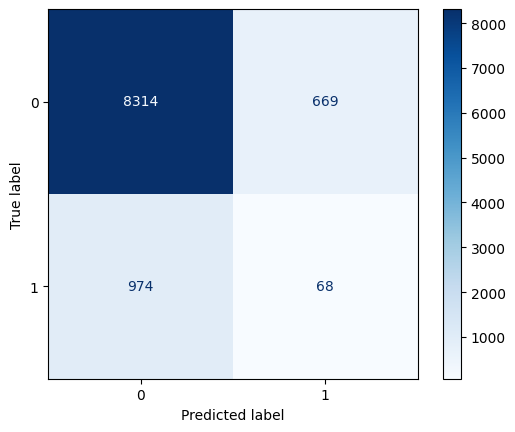

In [22]:
results(ytest,y_pred,plot_confusion = True)

In [23]:
import pandas as pd

# Assuming df is your DataFrame
df = pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")

# Extract the '100% SSL' column and convert it to a dictionary
ssl_dict = df.set_index('Results')['100% SSL'].to_dict()

# Display the created dictionary
ssl_dict={'100% ssl':{'accuracy': 0.913217, 'f1': 0.696559, 'precision': 0.797193, 'recall': 0.654645}}


In [24]:
file_path = "dictionary2.pkl"

# Open the file in write mode
with open(file_path, "wb") as file:
    # Write the dictionary to the file
    pickle.dump(ssl_dict, file)

NameError: name 'pickle' is not defined

In [ ]:
import pickle

# Load the dictionaries from the files
with open("merged_dictionary.pkl", "rb") as file1, open("dictionary2.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary.pkl", "wb") as file:
    pickle.dump(merged_dict, file)

In [ ]:
resdf = pd.DataFrame(merged_dict)
resdf


,50% ssl,100% No_ssl,100% ssl
accuracy,0.900050,0.885885,0.913217
f1,0.653781,0.588336,0.696559
precision,0.729032,0.649453,0.797193
recall,0.622695,0.570252,0.654645
